<a href="https://colab.research.google.com/github/mfan86/w266/blob/main/mikefan_w266project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import string
import random
import time
import os
os.environ['PYTHONHASHSEED'] = '11'
np.random.seed(22)
random.seed(33)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

import seaborn as sns
sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

import spacy
import nltk
import re

from plotly.subplots import make_subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data

In [8]:
train_df = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)
train_df.head()

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# EDA

Class Imbalance

---


Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. With just 6.6% of our dataset belonging to the target class, we can definitely have an imbalanced class.

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use. Classification accuracy is defined as the number of correct predictions divided by total predictions times 100. For example, if we simply predicted that all questions are sincere, we would get a classification acuracy score of 93%.

Thus, we will use the F1-score as the evaluation metric as it balances between precision and recall:


*   Precision is the number of true positives divided by all positive predictions. It's a measure of a classifier's exactness where low precision indicates a high number of false positives
*   Recall is the number of true positives divided by the number of positive values in the test data. It is a measure of a classifier's completeness where ow recall indicates a high number of false negatives

In [24]:
sin = len(train_df[train_df["target"]==0])
insin = len(train_df[train_df["target"]==1])
persin = (sin/(sin+insin))*100
perinsin = (insin/(sin+insin))*100            
print("Count of Sincere questions is {:,} ({:.2f}%) and count of Insincere questions is {:,} ({:.2f}%)".format(sin,persin,insin,perinsin))
#print("# Test samples: {:,}({:.3f}% of train samples)".format(len(test_df),len(test_df)/len(train_df)))

Count of Sincere questions is 1,225,312 (93.81%) and count of Insincere questions is 80,810 (6.19%)


In [12]:
print('Average word length of questions in train is {0:.0f}'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [25]:
print('Max word length of questions in train is {0:.0f}'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [26]:
print('Average character length of questions in train is {0:.0f}'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 71.


In [89]:
print('Count of unique words in train is {:,}'.format(np.sum(train_df["question_text"].apply(lambda x: len(str(x).split())))))
print('Count of unique words in test is {:,}'.format(np.sum(test_df["question_text"].apply(lambda x: len(str(x).split())))))

Count of unique words in train is 16,723,076.
Count of unique words in test is 4,814,391.


In [92]:
stop_words = set(stopwords.words('english')) #from nltk
print('Count of stop words in train is {:,}'.format(np.sum(train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words])))))
print('Count of stop words in test is {:,}'.format(np.sum(test_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words])))))

Count of stop words in train is 8,047,469
Count of stop words in test is 2,316,645


In [94]:
print('Count of punctuations in train is {:,}'.format(np.sum(train_df["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])))))
print('Count of punctuations in test is {:,}'.format(np.sum(test_df["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])))))

Count of punctuations in train is 2,281,132
Count of punctuations in test is 655,266


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


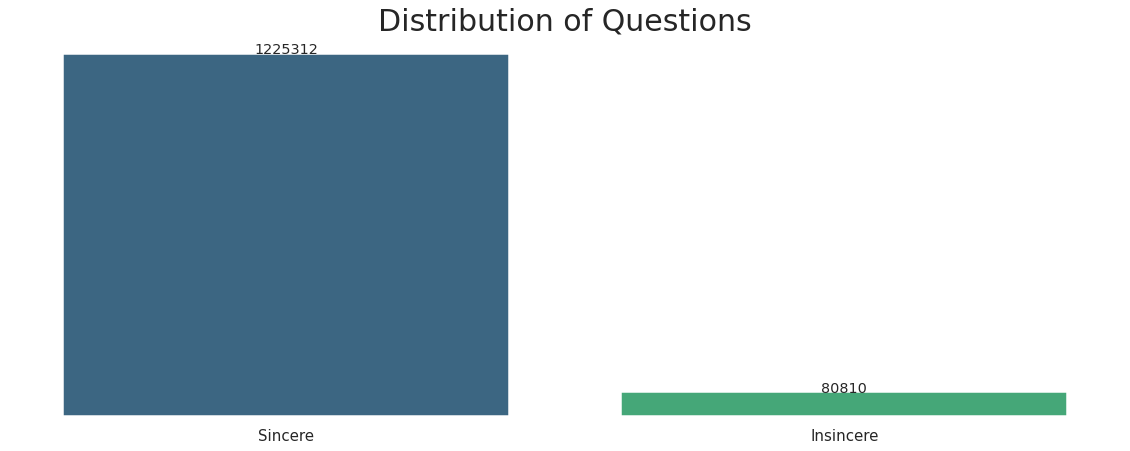

In [30]:
# show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(train_df.target, palette='viridis')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Questions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

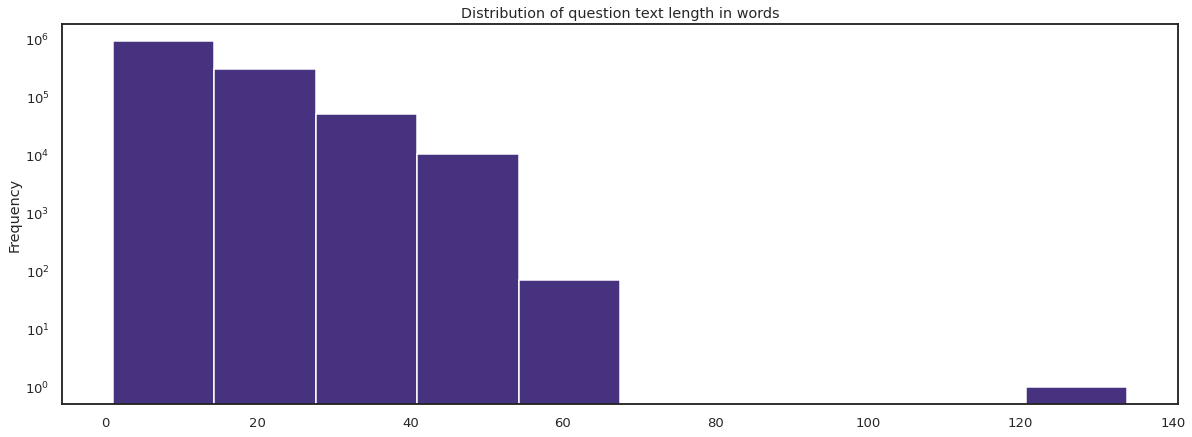

In [101]:
# distribution of question length in words
max_features = 90000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train_df['question_text'].values) + list(test_df['question_text'].values)
tk.fit_on_texts(full_text)

train_tokenized = tk.texts_to_sequences(train_df['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test_df['question_text'].fillna('missing'))

train_df['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')
plt.show()

**Observations:**
* Most of the questions are 40 words or less
* There are outliers with relaively long questions in the 100-120 word length
* Weighted attention mechanism with Bi-directional LSTM maybe needed to handle long questions with multiple sentences

In [80]:
from collections import defaultdict

train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

# custom function for ngram generation
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# custom function for horizontal bar chart
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# get the bar chart from sincere questions
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# get the bar chart from insincere questions
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# create two subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=2000, title="Unigram Word Count", title_x=0.5)

fig.show(renderer="colab")

**Observations**: 

*   Some top words are common across both the classes such as 'people', 'will', 'think'
*   The other top words in sincere questions after excluding the common ones at the very top are 'best', 'good'
* The other top words in insincere questions after excluding the common ones are 'trump', 'women', 'white'

This doesn't tell us much, I'll create a bigram frequency plots for both the classes separately to get an better understanding of word relationships

In [79]:
# get the bar chart from sincere questions (bigram)
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# get the bar chart from insincere questions
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# create two subplots
fig2 = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig2.append_trace(trace0, 1, 1)
fig2.append_trace(trace1, 1, 2)
fig2['layout'].update(height=1200, width=2000, title="Bigram Word Count", title_x=0.5)

fig2.show(renderer="colab")

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Observations:**

* Bigram word frequency in *sincere* questions seem to be more neutral in semantic meaning
* Bigram word frequency in *insincere* questions seem to be focused on Donald Trump, race and sexual orientation, all potential topics where toxicity can flourish

# Text Preprocessing and Normalization

In [12]:
def load_and_process():
    train_df = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/train.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/test.csv")
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=.2, random_state=123)

    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index